In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime

''' read in data and format test time '''
df = pd.read_csv('wifi_test.csv', index_col=0)
df = df.reset_index()
df['test_time']=df['index'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H:%M:%S'))

''' encode deivce ssid '''
ssid_dict = {}
for c,i in enumerate(df.device_ssid.unique()):
    ssid_dict[i] = c+1

df['ssid_id'] = df.device_ssid.apply(lambda x: ssid_dict[x])


In [2]:
df.shape

(4441, 7)

In [3]:
df.tail()

,index,down,up,device_ip,device_ssid,test_time,ssid_id
4436,2021113_23:13:48,78.48,31.70,192.168.1.14,Password's On The Fridge,2021-11-03 23:13:48,2
4437,2021113_23:14:9,74.63,30.03,192.168.1.14,Password's On The Fridge,2021-11-03 23:14:09,2
4438,2021113_23:14:30,73.49,40.99,192.168.1.14,Password's On The Fridge,2021-11-03 23:14:30,2
4439,2021113_23:14:50,70.73,18.64,192.168.1.14,Password's On The Fridge,2021-11-03 23:14:50,2
4440,2021113_23:15:10,70.93,30.74,192.168.1.14,Password's On The Fridge,2021-11-03 23:15:10,2


## set datetime range

In [4]:
dt_start = datetime.datetime.strptime('20211020_7:00:00', "%Y%m%d_%H:%M:%S")
dt_end = datetime.datetime.strptime('20211231_23:00:00', "%Y%m%d_%H:%M:%S")

df = df[(df.test_time>dt_start)&(df.test_time<dt_end)]

df.shape

(4441, 7)

### drop na

In [5]:
df = df.dropna()

## plot all data

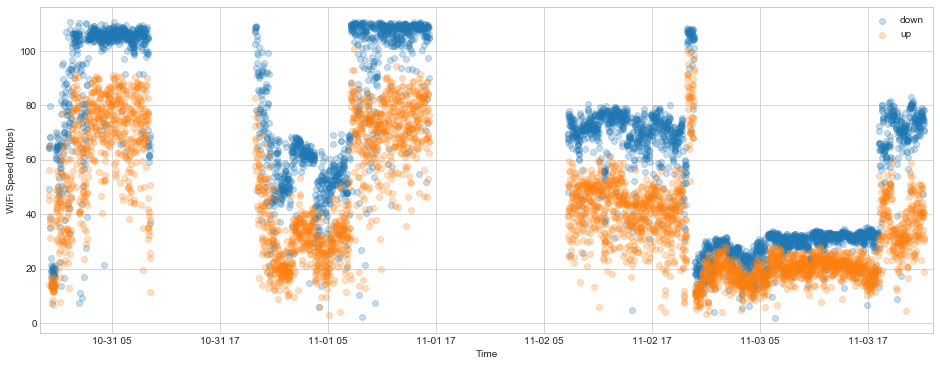

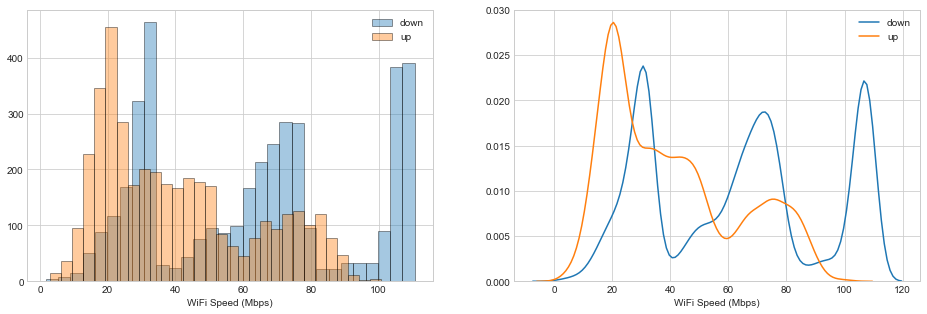

In [6]:
plt.style.use('seaborn-whitegrid')

edgecolors = ['red','green','yellow','black','purple']
fillcolors = {'up':'blue',
              'down':'orange'}
df['color'] = df.ssid_id.apply(lambda x: edgecolors[x-1])
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
for i in df[['down','up']]:
    ax.scatter(x=df.test_time.values, y=df[i],
               alpha=0.25, 
               #facecolors=fillcolors[i],
               #color=fillcolors[i],
               #edgecolor=df.color,
               #plotnonfinite=True,
               label=i)

ax.set_xlim(df.test_time.min() - datetime.timedelta(hours=1),
            df.test_time.max() + datetime.timedelta(hours=1))
ax.set_xlabel('Time')
ax.set_ylabel('WiFi Speed (Mbps)')
ax.legend()

fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
for i in df[['down','up']]:
    ax2.hist(df[i].fillna(0), bins=30, edgecolor='black', alpha=0.4,density=False)
    sns.kdeplot(df[i].fillna(0), bw=3)
    
ax2.set_xlabel('WiFi Speed (Mbps)')
ax2.legend()
ax3.set_xlabel('WiFi Speed (Mbps)');

## plot all by SSID

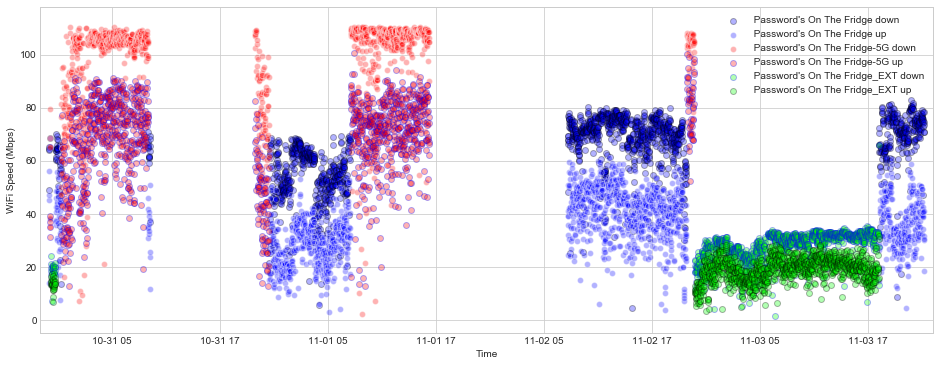

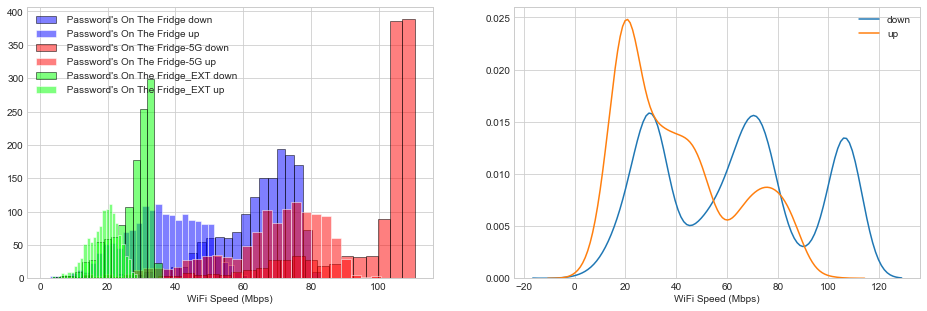

In [7]:
plt.style.use('seaborn-whitegrid')

edgecolors = ['black','white','blue','black','purple']
fillcolors = {'down':'blue',
              'up':'orange'}

colors = cm.brg(np.linspace(0, 1, df.device_ssid.nunique()))
#df['color'] = df.ssid_id.apply(lambda x: edgecolors[x-1])
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)

for c,ssid in enumerate(df.groupby('device_ssid')):
    df_ = ssid[1]
    for d,i in enumerate(df_[['down','up']]):
        ax.scatter(x=df_.test_time.values, y=df_[i],
                   alpha=0.3, 
                   label="%s %s" %(ssid[0],i),
                   color=colors[c],
                   edgecolors=edgecolors[c+d]
                  )

ax.set_xlim(df.test_time.min() - datetime.timedelta(hours=1),
            df.test_time.max() + datetime.timedelta(hours=1))
ax.set_ylim(-5, 118)
ax.set_xlabel('Time')
ax.set_ylabel('WiFi Speed (Mbps)')
ax.legend()



fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
for c,ssid in enumerate(df.groupby('device_ssid')):
    df_ = ssid[1]
    for d,i in enumerate(df_[['down','up']]):
        ax2.hist(df_[i],
                 bins=30,
                 color=colors[c],
                 edgecolor=edgecolors[d],
                   alpha=0.5,
                label="%s %s" %(ssid[0],i))
        
for i in df_[['down','up']]:
    sns.kdeplot(df[i].fillna(0))
    
ax2.set_xlabel('WiFi Speed (Mbps)')
ax2.legend()
ax3.set_xlabel('WiFi Speed (Mbps)');

## plot the last N hours, broken out by SSID (if more than 1 exist)

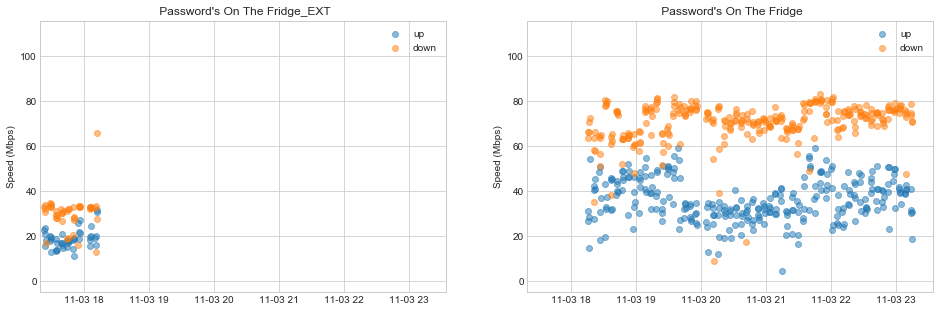

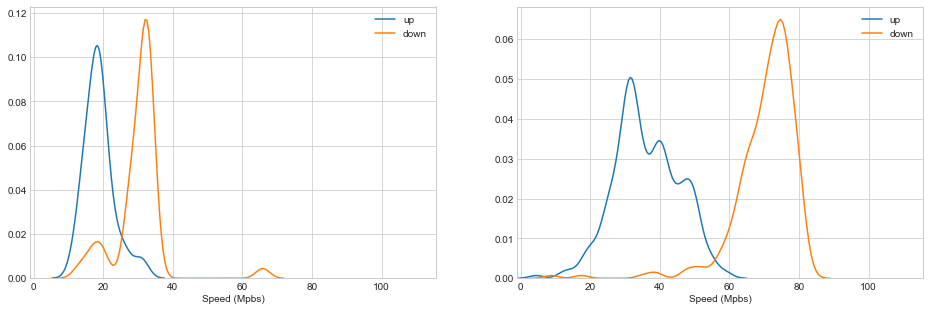

In [8]:
fig1 = plt.figure(figsize=(16,5))
fig2 = plt.figure(figsize=(16,5))

window = 6  # hours
df_ = df[df.test_time>=datetime.datetime.now() - datetime.timedelta(hours=window)]
df_ = df_.dropna()

for c,ssid in enumerate(df_.device_ssid.unique()):
    #plot_num = df_.device_ssid.nunique() - c
    plot_num = c+1
    #print(ssid, plot_num)
    ssid_df = df_[df_.device_ssid==ssid]
    ax1 = fig1.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    ax2 = fig2.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    plot_num+=1

    for i in ssid_df[['up','down']]:
        ''' scatter plot '''
        x,y = ssid_df.test_time, ssid_df[i]
        ax1.scatter(x.values, y,
                  alpha=0.5)
        #ax1.set_xticks(x_range)
        ax1.set_xlim(datetime.datetime.now() - datetime.timedelta(hours=window),
                    datetime.datetime.now()+datetime.timedelta(hours=.25))
        ax1.set_ylim(-5, df.down.max()+5)
        ax1.title.set_text(ssid)
        ax1.legend()
        ''' kde plots '''
        sns.kdeplot(ssid_df[i], bw=2)
        ax2.set_xlabel('Speed (Mpbs)')
        ax2.set_xlim(-1, df.down.max()+5)
    ax1.set_ylabel('Speed (Mbps)')
    
        #sns.kdeplot(data=ssid_df[i])
    


## Plot all data broken out by SSID

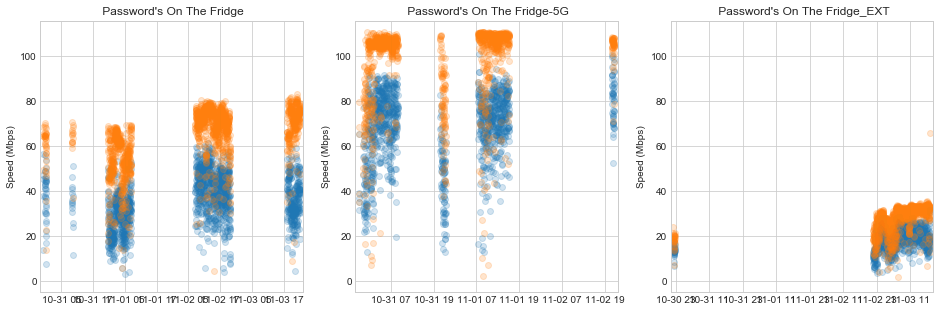

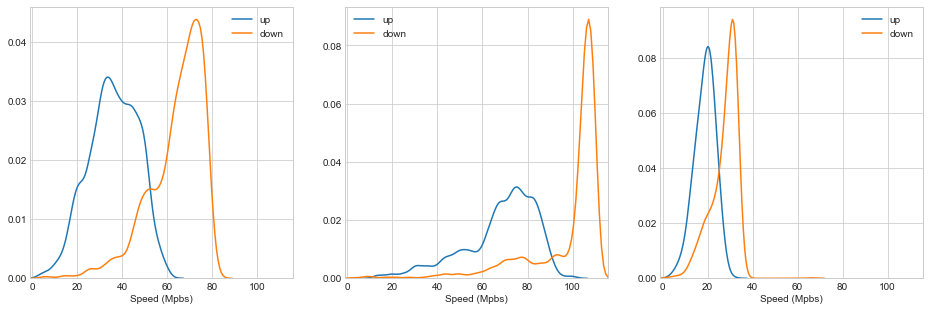

In [9]:
fig1 = plt.figure(figsize=(16,5))
fig2 = plt.figure(figsize=(16,5))

df_ = df.dropna()
x_range = pd.date_range(df.test_time.min() - datetime.timedelta(hours=1),
                        df.test_time.max() + datetime.timedelta(hours=1),
                        freq='1H')

for c,ssid in enumerate(df_.device_ssid.unique()):
    #plot_num = df_.device_ssid.nunique() - c
    plot_num = c+1
    #print(ssid, plot_num)
    ssid_df = df[df.device_ssid==ssid]
    ax1 = fig1.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    ax2 = fig2.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    plot_num+=1

    for i in ssid_df[['up','down']]:
        ''' scatter plot '''
        x,y = ssid_df.test_time, ssid_df[i]
        ax1.scatter(x.values, y,
                  alpha=0.2)
        #ax1.set_xticks(x_range)
        ax1.set_xlim(ssid_df.test_time.min() - datetime.timedelta(hours=1),
            ssid_df.test_time.max() + datetime.timedelta(hours=1))
        ax1.set_ylim(-5, df.down.max()+5)
        ax1.title.set_text(ssid)
        ''' kde plots '''
        sns.kdeplot(ssid_df[i], bw=2)
        ax2.set_xlabel('Speed (Mpbs)')
        ax2.set_xlim(-1, df.down.max()+5)
    ax1.set_ylabel('Speed (Mbps)')
    
        #sns.kdeplot(data=ssid_df[i])
    
